<a href="https://colab.research.google.com/github/JSJeong-me/GPT-Graph/blob/main/01-Graph-Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openai==0.28
!pip install python-dotenv
!pip install langchain langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 694.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 17.9 MB/s eta 0:00:00


In [3]:
# !echo "OPENAI_API_KEY=sk-" >> .env
# !source /content/.env

In [4]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
# Access the API key using the variable name defined in the .env file
api_key = os.getenv("OPENAI_API_KEY")

In [5]:
import openai

question = "When did apple announced the Vision Pro?"
completion = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                          temperature=0,
                                          messages=[{"role": "user",
                                                     "content": question}])
print(completion["choices"][0]["message"]["content"])

Apple announced the Vision Pro on October 18, 2021.


### Sentence-Level Knowledge Graphs

In [6]:
from langchain.llms import OpenAI
from langchain.indexes import GraphIndexCreator
from langchain.chains import GraphQAChain
from langchain.prompts import PromptTemplate

text = "Apple announced the Vision Pro in 2023."

index_creator = GraphIndexCreator(llm=OpenAI(temperature=0))
graph = index_creator.from_text(text)
graph.get_triples()

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


[('Apple', 'Vision Pro', 'announced'),
 ('Vision Pro', '2023', 'was released in')]

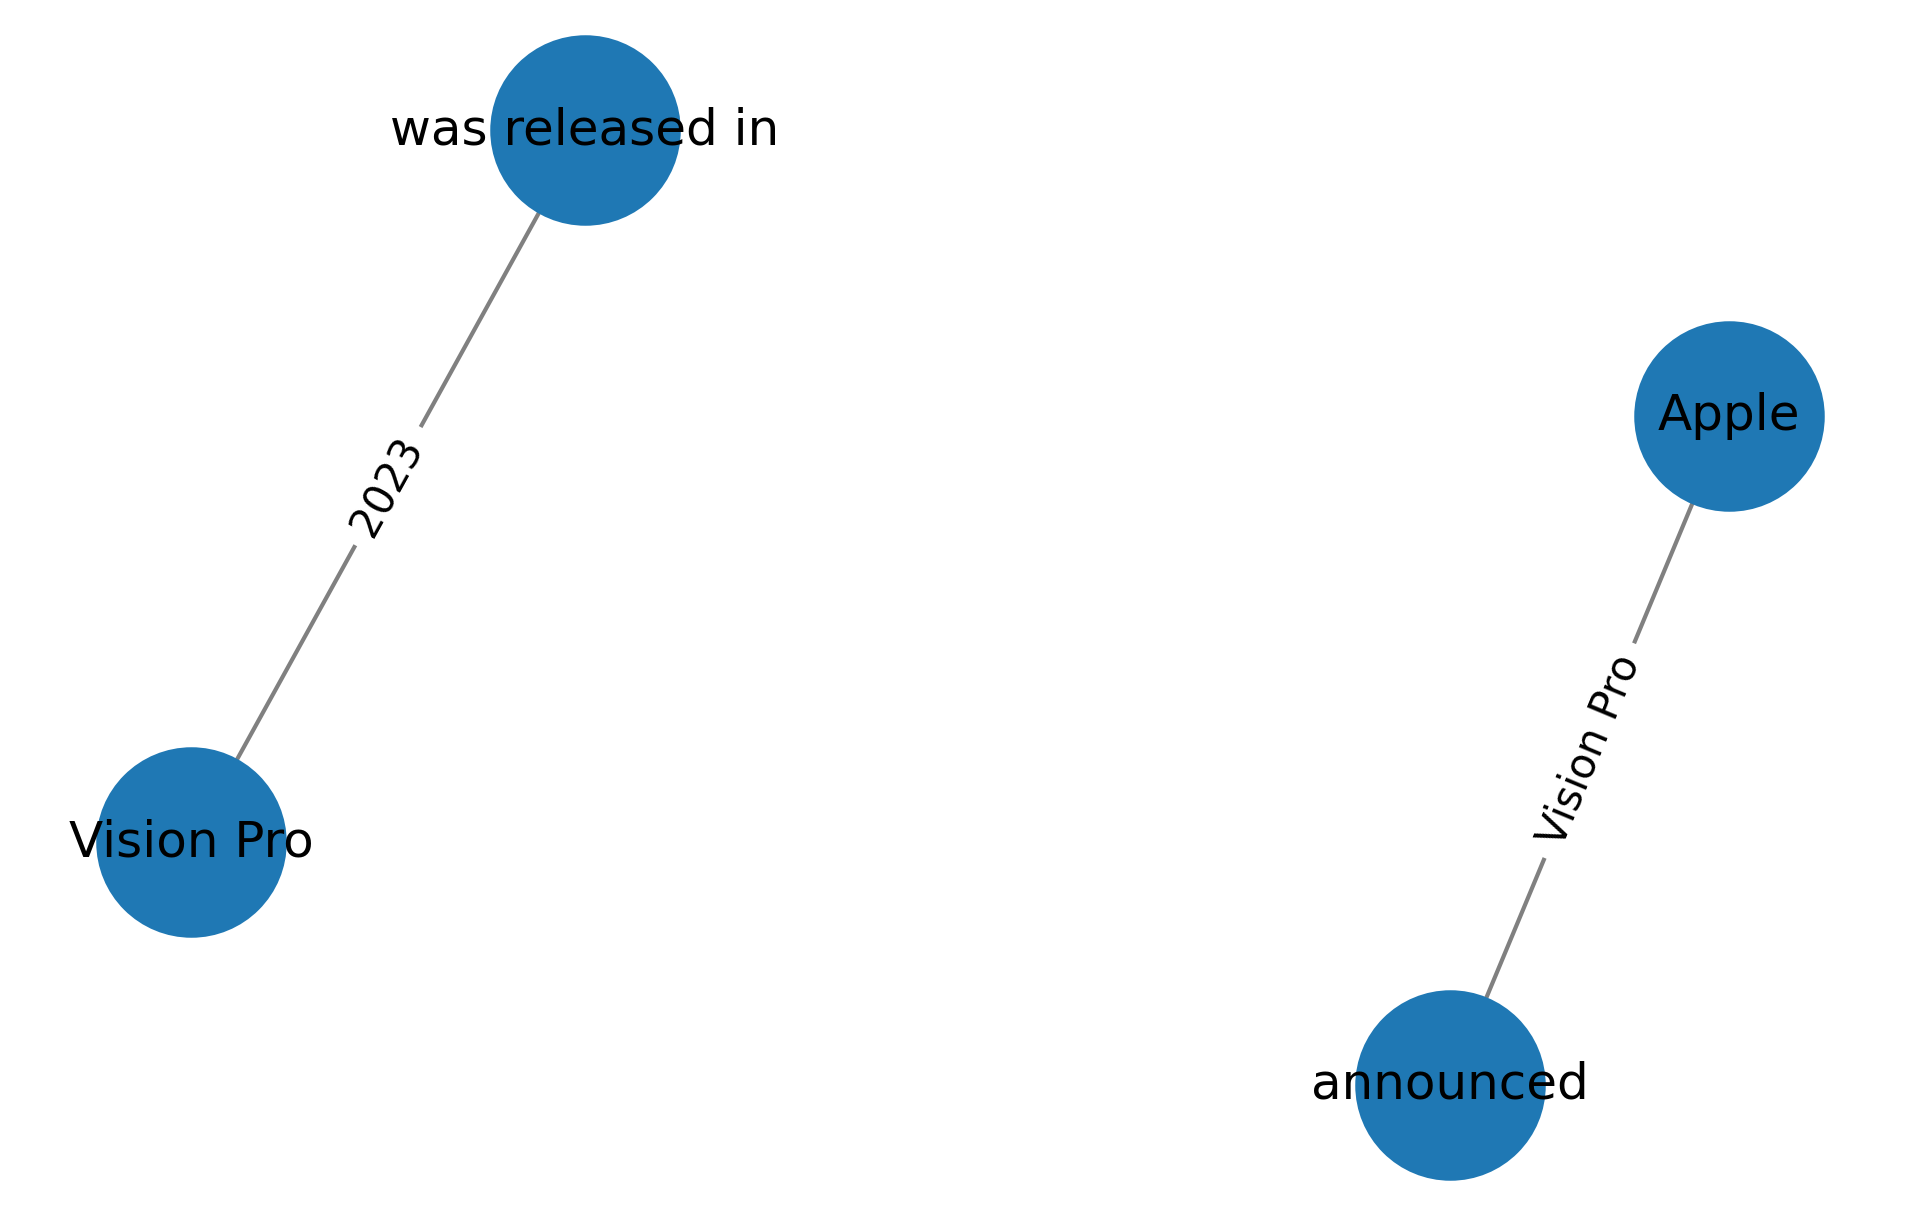

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.DiGraph()
G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in graph.get_triples())

# Plot the graph
plt.figure(figsize=(8,5), dpi=300)
pos = nx.spring_layout(G, k=3, seed=0)

nx.draw_networkx_nodes(G, pos, node_size=2000)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Display the plot
plt.axis('off')
plt.show()

In [8]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)
chain.run(question)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(




> Entering new GraphQAChain chain...
Entities Extracted:
 apple, Vision Pro
Full Context:
Vision Pro was released in 2023

> Finished chain.


" I don't know."

### Bigger Knowledge Graphs

In [9]:
from langchain.graphs.networkx_graph import KnowledgeTriple

# Knowledge graph
kg = [
    ('Apple', 'is', 'Company'),
    ('Apple', 'created', 'iMac'),
    ('Apple', 'created', 'iPhone'),
    ('Apple', 'created', 'Apple Watch'),
    ('Apple', 'created', 'Vision Pro'),

    ('Apple', 'developed', 'macOS'),
    ('Apple', 'developed', 'iOS'),
    ('Apple', 'developed', 'watchOS'),

    ('Apple', 'is located in', 'USA'),
    ('Steve Jobs', 'co-founded', 'Apple'),
    ('Steve Wozniak', 'co-founded', 'Apple'),
    ('Tim Cook', 'is the CEO of', 'Apple'),

    ('iOS', 'runs on', 'iPhone'),
    ('macOS', 'runs on', 'iMac'),
    ('watchOS', 'runs on', 'Apple Watch'),

    ('Apple', 'was founded in', '1976'),
    ('Apple', 'owns', 'App Store'),
    ('App Store', 'sells', 'iOS apps'),

    ('iPhone', 'announced in', '2007'),
    ('iMac', 'announced in', '1998'),
    ('Apple Watch', 'announced in', '2014'),
    ('Vision Pro', 'announced in', '2023'),
]

graph = index_creator.from_text('')
for (node1, relation, node2) in kg:
    graph.add_triple(KnowledgeTriple(node1, relation, node2))

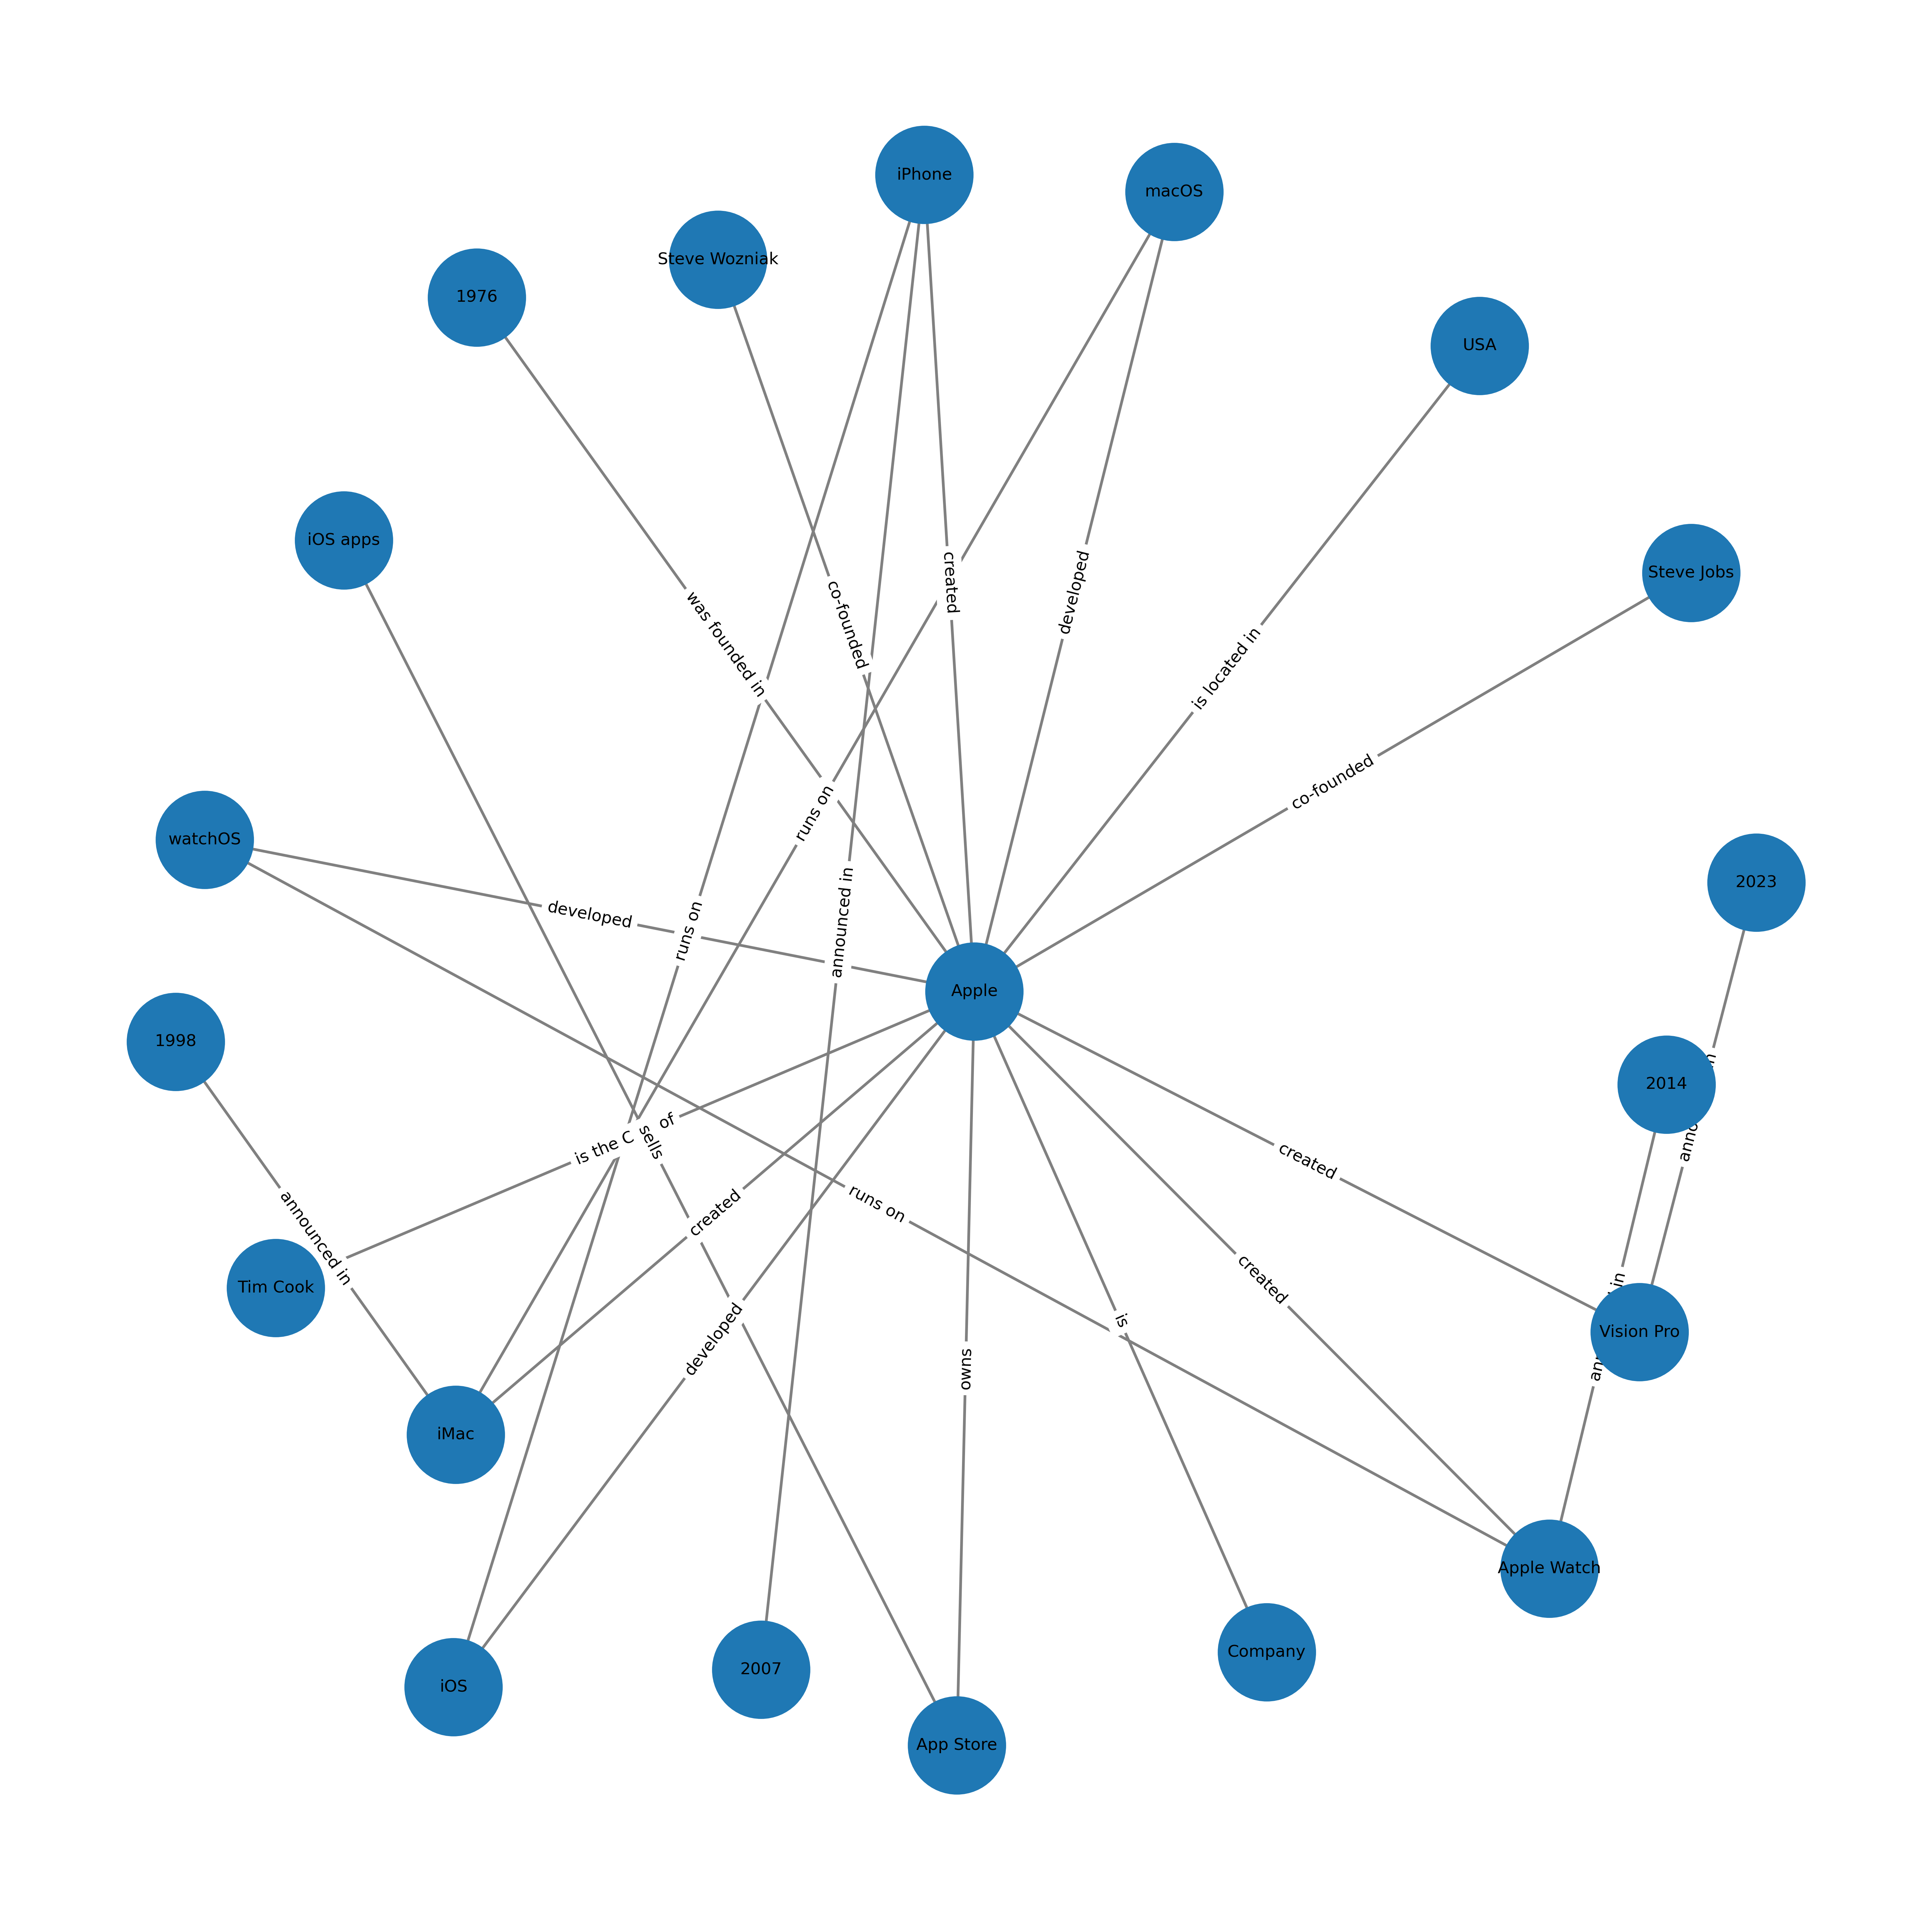

In [10]:
# Create directed graph
G = nx.DiGraph()
for node1, relation, node2 in kg:
    G.add_edge(node1, node2, label=relation)

# Plot the graph
plt.figure(figsize=(25, 25), dpi=300)
pos = nx.spring_layout(G, k=2, iterations=50, seed=0)

nx.draw_networkx_nodes(G, pos, node_size=5000)
nx.draw_networkx_edges(G, pos, edge_color='gray', edgelist=G.edges(), width=2)
nx.draw_networkx_labels(G, pos, font_size=12)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

# Display the plot
plt.axis('off')
plt.show()

### With this larger graph, we once again ask ChatGPT the question: “When did Apple announce the Vision Pro?” Leveraging the GraphQAChain object, ChatGPT processes the information embedded in the knowledge graph.

In [11]:
question = "Apple announced the Vision Pro in 2023."

In [12]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
 Apple, Vision Pro
Full Context:
Apple is Company
Apple created iMac
Apple created iPhone
Apple created Apple Watch
Apple created Vision Pro
Apple developed macOS
Apple developed iOS
Apple developed watchOS
Apple is located in USA
Apple was founded in 1976
Apple owns App Store
Vision Pro announced in 2023

> Finished chain.


' Yes'